# Bottleneck layer + static grid sample

I've realised it's easier/simpler for this simple 1D case to sample the functions at the same points for each sample. That way I don't need to pass the x coords in as well and hopefully the network's job is easier since it can directly portion off areas of the input space.

I don't think this would scale too well to higher dimensional input spaces though where the data distribution only sparsely and inhomogenously covers the space. In this situation, a static grid sample wouldn't give enough information in the important areas of interest for the function. Still, here it's just to demonstrate the idea.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.notebook import tqdm
import pandas as pd

from physics_mi.utils import set_all_seeds

In [3]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 3006203676
set_all_seeds(seed)
print(seed)

3006203676


In [26]:
class config:
    # 1D function model(s)
    N_FUNCS = 5
    TRAIN_SIZE = 8000
    VALID_SIZE = 2000
    MODELS_PER_FUNC = 100
    MODEL_HIDDEN_DIM = 128

    # Embedder model
    N_SAMPLES = 128
    EPOCHS = 200
    BOTTLE_DIM = 4

## Train source models

Not sure what to call these - so many models to refer to. These are the ones I'm going to classify.

In [5]:
from physics_mi.eval import *


def generate_polynomial(n=20):
    coeffs = np.random.rand(n) * 2 - 1
    return np.polynomial.Polynomial(coeffs)


def generate_waveform(n=10, frequency_scale=0.3):
    """
    Generates a funky curve using a Fourier series with n terms, in a vectorized manner.

    Parameters:
    - n: Number of terms in the Fourier series.
    - frequency_scale: Scales the frequencies of the sine and cosine terms.

    Returns:
    A function that takes an array of x values and returns the corresponding y values, calculated in a vectorized way.
    """
    # Random coefficients for sine and cosine terms
    a_coeffs = np.random.rand(n) * 2 - 1  # Coefficients for cosine terms
    b_coeffs = np.random.rand(n) * 2 - 1  # Coefficients for sine terms
    frequencies = np.arange(1, n + 1) * frequency_scale  # Frequency scaling

    def fourier_series(x):
        # Creating a 2D grid where each row corresponds to x and each column to a term in the series
        x_grid = np.outer(x, frequencies)

        # Calculating the sum of all sine and cosine terms at once
        y = np.dot(np.cos(np.pi * x_grid), a_coeffs) + np.dot(np.sin(np.pi * x_grid), b_coeffs)
        return y

    return fourier_series


def plot_funcs(funcs):
    nrows = len(funcs) // 5 + 1
    ncols = min(len(funcs), 5)
    fig = plt.figure(figsize=(ncols * 3, nrows * 3))

    x = np.linspace(-1, 1, 100)
    for i, func in enumerate(funcs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.plot(x, func(x))
        ax.set_title(f"Function {i}")


def generate_X(size):
    return np.random.rand(size) * 2 - 1


class FuncData:
    def __init__(self, func, size: int) -> None:
        self.func = func
        self.size = size
        self.X = generate_X(size)
        self.Y = self.func(self.X)
        self.torchify_data()

    def torchify_data(self):
        self.X = torch.as_tensor(self.X).float()[:, None]
        self.Y = torch.as_tensor(self.Y).float()[:, None]


def generate_func_data(funcs, train_size, valid_size):
    return [
        {
            "train": FuncData(func, train_size),
            "valid": FuncData(func, valid_size),
        }
        for func in funcs
    ]


class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def get_model():
    return Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)


def train_model(train_data, valid_data):
    N = 100  # number of epochs

    model = Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)
    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=1e-1)
    log = []

    for i in range(N):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(train_data.X)
        loss = loss_func(Y_hat, train_data.Y)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(valid_data.X)
        loss = loss_func(Y_hat, valid_data.Y)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    log = pd.DataFrame(log)

    return model, log


def get_preds(model, valid_data):
    model.eval()

    with torch.inference_mode():
        out = model(valid_data.X)

    y_preds = out.numpy()[:, 0]
    y_targs = valid_data.Y.numpy()[:, 0]

    return y_preds, y_targs


def plot_models(df, data, title=None):
    fig = plt.figure(figsize=(15, 6))

    pdf = df.reset_index(drop=True)

    nrows = len(pdf) // 5 + 1
    ncols = min(len(pdf), 5)
    fig = plt.figure(figsize=(ncols * 3, nrows * 3))

    for i, row in pdf.iterrows():
        ax = fig.add_subplot(nrows, ncols, i + 1)
        model = get_model()
        model.load_state_dict(row["model"])
        valid_data = data[row["func"]]["valid"]

        y_preds, _ = get_preds(model, valid_data)

        sort_idxs = torch.argsort(valid_data.X[:, 0]).numpy()
        x = valid_data.X.numpy()[sort_idxs]
        y = valid_data.Y.numpy()[sort_idxs]
        y_preds_plot = y_preds[sort_idxs]

        ax.scatter(x, y_preds_plot, s=5, label="Predicted", alpha=0.5, color="grey")
        ax.plot(x, y, label="True", color="salmon")

        _ = ax.set_title(f"Function {i}")

    if title is not None:
        fig.suptitle(title)

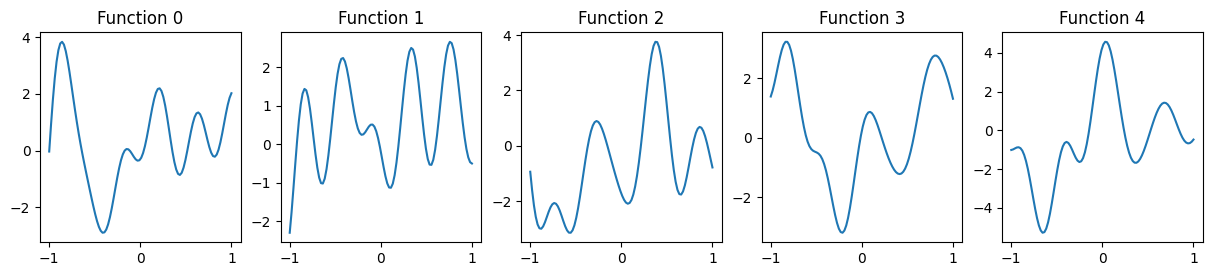

In [6]:
funcs = [generate_waveform(frequency_scale=0.5) for _ in range(config.N_FUNCS)]
data = generate_func_data(funcs, train_size=config.TRAIN_SIZE, valid_size=config.VALID_SIZE)
plot_funcs(funcs)

In [7]:
models = []
for i, (func, func_data) in tqdm(enumerate(zip(funcs, data)), total=len(data)):
    for j in tqdm(range(config.MODELS_PER_FUNC), leave=False):
        model, log = train_model(func_data["train"], func_data["valid"])
        row = {}
        row["func"] = i
        row["repeat"] = j
        row["model"] = model.state_dict()
        row["valid_loss"] = log["valid_loss"].iloc[-1]
        models.append(row)
    print("\n")

mdf = pd.DataFrame(models)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 1500x600 with 0 Axes>

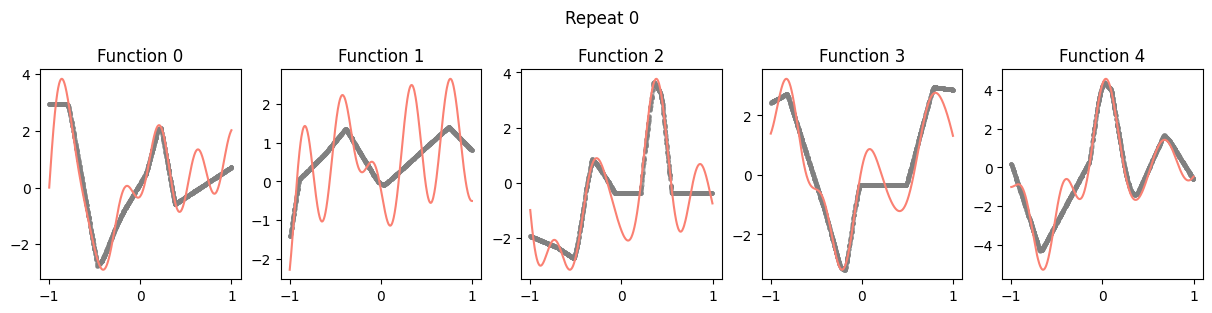

<Figure size 1500x600 with 0 Axes>

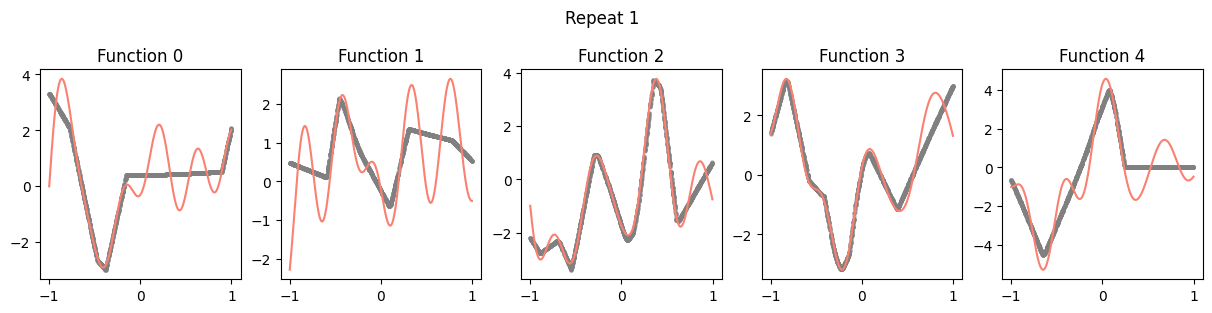

<Figure size 1500x600 with 0 Axes>

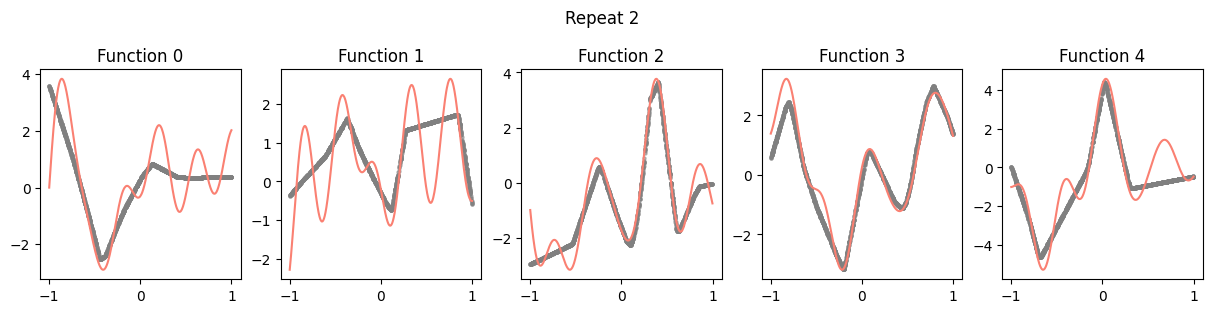

<Figure size 1500x600 with 0 Axes>

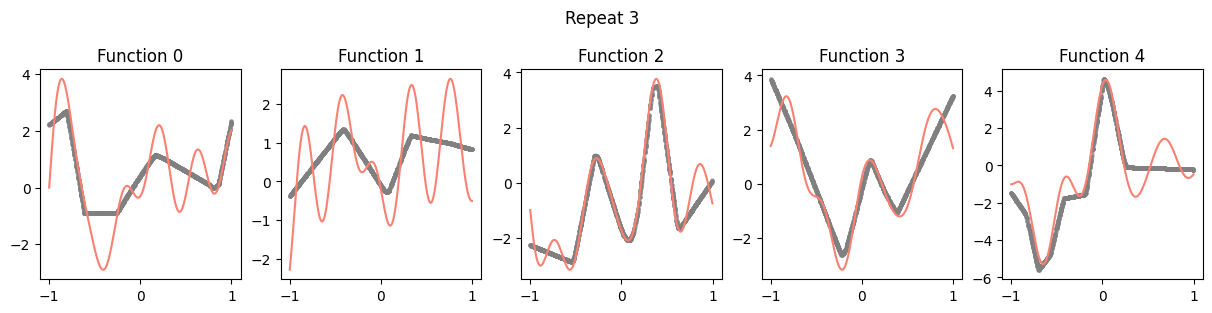

<Figure size 1500x600 with 0 Axes>

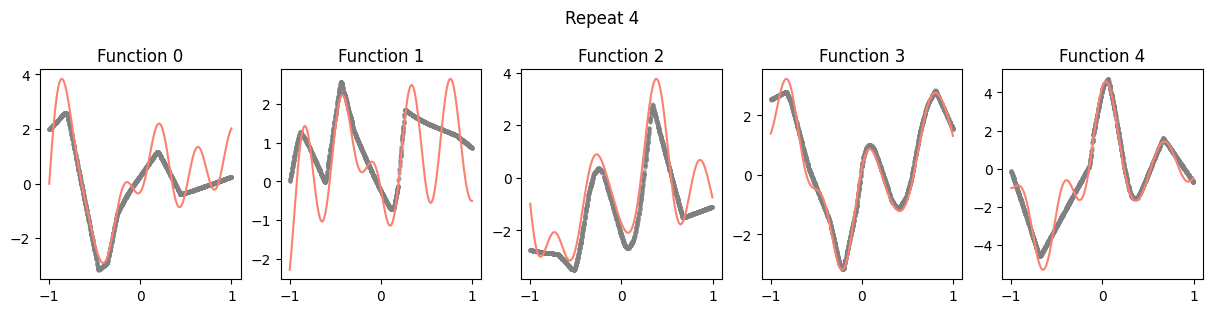

In [8]:
for i in range(5):
    _ = plot_models(mdf.loc[mdf["repeat"] == i], data, title=f"Repeat {i}")

Now plotting all the repeats for each function to see if they're distinguishable:

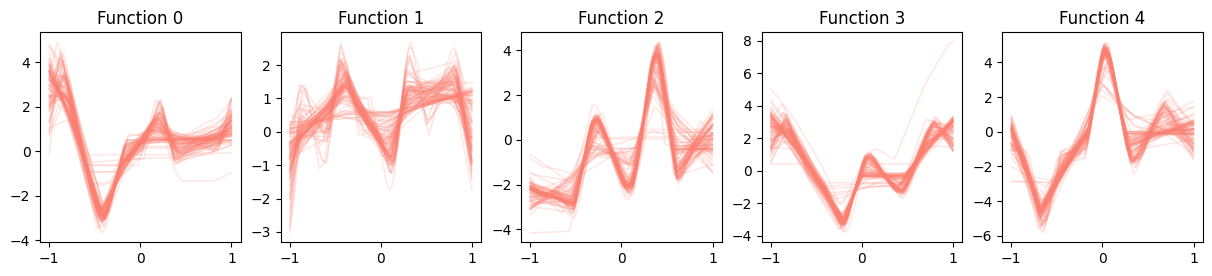

In [9]:
nrows = len(funcs) // 5 + 1
ncols = min(len(funcs), 5)
fig = plt.figure(figsize=(ncols * 3, nrows * 3))

for f, func in enumerate(funcs):
    ax = fig.add_subplot(nrows, ncols, f + 1)
    valid_data = data[f]["valid"]
    sort_idxs = torch.argsort(valid_data.X[:, 0]).numpy()
    x = valid_data.X.numpy()[sort_idxs]
    for r in range(config.MODELS_PER_FUNC):
        row = mdf.loc[(mdf["func"] == f) & (mdf["repeat"] == r)].iloc[0]
        model = get_model()
        model.load_state_dict(row["model"])

        y_preds, _ = get_preds(model, valid_data)
        y_preds_plot = y_preds[sort_idxs]

        ax.plot(x, y_preds_plot, lw=1, label="Predicted", alpha=0.2, color="salmon")
    ax.set_title(f"Function {f}")

Ok so we can see that there is some underfitting (could probably have increased model capacity/decreased number of fourier components) but importantly, the shape between repeats seems to be fairly consistent (and distinct) 👍 which is what we need for the next model to learn distinguishing features.

In [11]:
models_name = f"fourier_models_{config.N_FUNCS}"
# mdf.to_pickle(f"models/{models_name}.pkl")

## Train model embedder

Here's where it gets interesting.

So far we've trained 50 different networks to model each of our 10 1D polynomials. The plan now is to use these as training data for our auxiliary model i.e. the one that's going to be generating embeddings. 

### Data

In [170]:
mdf = pd.read_pickle(f"models/{models_name}.pkl")

<Axes: >

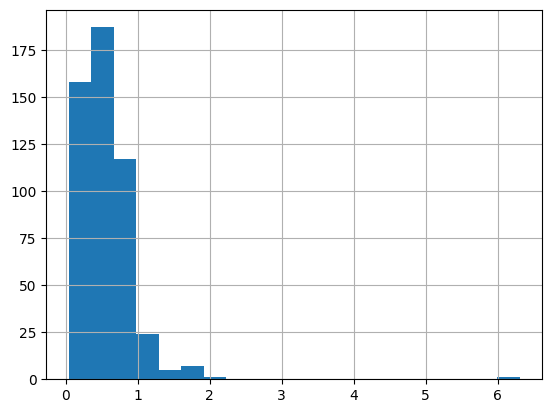

In [171]:
mdf.valid_loss.hist(bins=20)

Let's remove some of those high-loss models that probably aren't going to provide us with enough line sections to learn anything meaningful.

In [172]:
thresh = 1.5
(mdf.valid_loss < thresh).mean()

0.98

In [173]:
mdf = mdf.loc[mdf.valid_loss < thresh].reset_index(drop=True)
mdf.groupby("func")["func"].count()

func
0     98
1    100
2     96
3     99
4     97
Name: func, dtype: int64

Some functions were obviously harder to model than others.

In [174]:
from physics_mi.utils import unique


class GradientDataset(Dataset):
    def __init__(self, df: pd.DataFrame, n_samples: int = 10, mask: bool = True):
        self.df = df.reset_index(drop=True)
        self.n_samples = n_samples
        self.mask = mask

    def __len__(self) -> int:
        return len(self.df)

    def generate_X(self):
        X = torch.linspace(-1, 1, self.n_samples)[:, None]
        X.requires_grad_(True)
        return X

    def __getitem__(self, i):
        row = self.df.iloc[i]
        model = get_model()
        model.load_state_dict(row["model"])
        for param in model.parameters():
            param.requires_grad = False
        X = self.generate_X()
        out = model(X)
        loss = out.mean()
        loss.backward()
        input_grads = X.grad.clone().detach()
        if self.mask:
            uq_grads, _, _, index = unique(input_grads)
            uq_grads = uq_grads[torch.argsort(index)]
            n_grads = len(uq_grads)
            window_size = int(n_grads // 3)
            window_start = np.random.randint(0, n_grads - window_size)
            mask_grads = uq_grads[window_start : window_start + window_size]
            mask = torch.isin(input_grads, mask_grads)
            masked = input_grads.clone()
            masked[mask] = -1
            x = masked.view(-1)
        else:
            x = input_grads.view(-1)
        y = input_grads.view(-1)  # TODO potentially mask out the y values too in order to focus the loss
        x = x.detach()
        y = y.detach()
        return x, y

In [175]:
from sklearn.model_selection import train_test_split

train_idxs, valid_idxs = train_test_split(mdf.index, test_size=0.2, stratify=mdf["func"], random_state=24)
mdf["valid"] = False
mdf.loc[valid_idxs, "valid"] = True

mdf.groupby("func")["valid"].value_counts()

func  valid
0     False    78
      True     20
1     False    80
      True     20
2     False    77
      True     19
3     False    79
      True     20
4     False    78
      True     19
Name: count, dtype: int64

In [176]:
train_ds = GradientDataset(mdf.loc[~mdf["valid"]], n_samples=config.N_SAMPLES)
valid_ds = GradientDataset(mdf.loc[mdf["valid"]], n_samples=config.N_SAMPLES)
eval_ds = GradientDataset(mdf.loc[mdf["valid"]], n_samples=config.N_SAMPLES, mask=False)

len(train_ds), len(valid_ds), len(eval_ds)

(392, 98, 98)

In [177]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)
eval_dl = DataLoader(eval_ds, batch_size=64, shuffle=False)

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

### Model

Going to add in a residual connection so that it can copy the unchanged grad inputs if it would like:

In [178]:
class GradNet(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, bottle_dim=4, output_dim=2, embedding_mode=False, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.down_layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, bottle_dim, use_act=True),
        )
        self.up_layers = LinearLayer(bottle_dim, output_dim, use_act=True)
        self.output_layer = LinearLayer(output_dim, output_dim, use_act=False)
        self.embedding_mode = embedding_mode

    def forward(self, x):
        out = self.down_layers(x)
        if self.embedding_mode:
            return out
        out = self.up_layers(out)
        out = out + x  # residual connection
        return self.output_layer(out)

### Train

In [179]:
from torch.optim.lr_scheduler import OneCycleLR

model = GradNet(input_dim=config.N_SAMPLES, hidden_dim=128, bottle_dim=config.BOTTLE_DIM, output_dim=config.N_SAMPLES)
optimiser = Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
total_steps = len(train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=1e-2, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    model.train()
    for xb, yb in train_dl:
        y_hat = model(xb)
        # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
        # loss = loss_func(y_hat[mask], yb[mask])
        loss = loss_func(y_hat, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    model.eval()
    valid_loss = 0
    for xb, yb in valid_dl:
        with torch.no_grad():
            y_hat = model(xb)
            # mask = xb.view(len(xb), -1, 2)[:, :, 1] == -1
            # valid_loss += nn.MSELoss()(y_hat[mask], yb[mask])
            valid_loss += nn.MSELoss()(y_hat, yb)

    log_sample["valid_loss"] = float(valid_loss / len(valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

In [180]:
torch.save(model.state_dict(), f"models/{models_name}.pth")

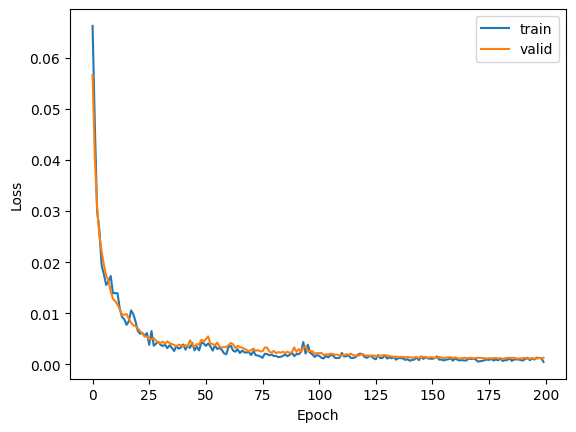

In [181]:
plot_loss(log["train_loss"], log["valid_loss"])

In [182]:
def get_preds(model, valid_dl):
    model.eval()

    X = []
    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        X.append(xb)
        y_preds.append(out)
        y_targs.append(yb)

    X = torch.cat(X).numpy()
    y_preds = torch.cat(y_preds).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs, X

In [183]:
y_preds, y_targs, X = get_preds(model, valid_dl)

X_grid = valid_ds.generate_X().detach().view(-1).numpy()
cloze_mask = X == -1
y_preds.shape, y_targs.shape, cloze_mask.shape

((98, 128), (98, 128), (98, 128))

In [184]:
i = 0

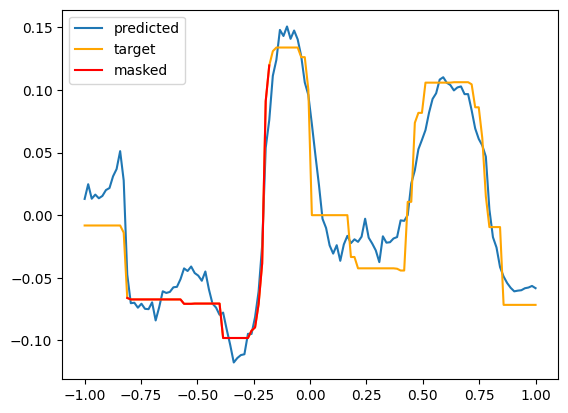

In [257]:
fig, ax = plt.subplots()

func = funcs[valid_ds.df.loc[i, "func"]]

ax.plot(X_grid, y_preds[i], label="predicted")
ax.plot(X_grid, y_targs[i], label="target", color="orange")
ax.plot(X_grid[cloze_mask[i]], y_targs[i, cloze_mask[i]], color="red", label="masked")
_ = ax.legend()
i += 1

Ok, it's by no means perfect, but it's doing ok enough I think to move to the next stage: visualising the embeddings.

### Embedding visualisation

In [258]:
embedder = GradNet(
    input_dim=config.N_SAMPLES,
    hidden_dim=128,
    bottle_dim=config.BOTTLE_DIM,
    output_dim=config.N_SAMPLES,
    embedding_mode=True,
)
embedder.load_state_dict(model.state_dict())

<All keys matched successfully>

In [261]:
y_preds, y_targs, X = get_preds(embedder, eval_dl)

In [262]:
func_labels = valid_ds.df["func"].values
y_preds.shape, func_labels.shape

((98, 4), (98,))

In [263]:
from pacmap import PaCMAP

model = PaCMAP()

y_preds_2d = model.fit_transform(y_preds)

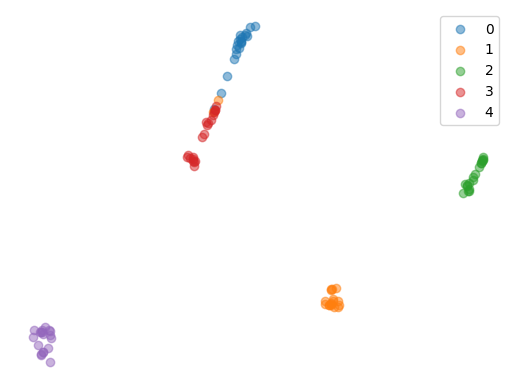

In [274]:
fig, ax = plt.subplots()

for lbl in np.unique(func_labels):
    mask = func_labels == lbl
    ax.scatter(y_preds_2d[mask, 0], y_preds_2d[mask, 1], label=lbl, alpha=0.5)

ax.legend()
_ = ax.axis("off")

## Linear probing

These plots are nice and all but let's quantify this to see if they're linearly separable. Not sure if it's allowed to test on the training data when you're using a linear probe? Are you not just testing to see how linearly separable the data is? Is there an issue of overfitting?

In [265]:
def train_linear_probe(X, y):
    model = nn.Linear(X.shape[1], len(np.unique(y)))
    optimiser = Adam(model.parameters(), lr=1)
    loss_func = nn.CrossEntropyLoss()
    X = torch.tensor(X).float()
    y = torch.tensor(y).long()
    log = []

    for epoch in tqdm(range(100)):
        log_sample = {}

        model.train()
        optimiser.zero_grad()
        y_hat = model(X)
        loss = loss_func(y_hat, y)
        loss.backward()
        optimiser.step()

        model.eval()
        y_hat = model(X)
        loss = loss_func(y_hat, y)
        log_sample["valid_loss"] = float(loss.detach())
        log.append(log_sample)

    return model, pd.DataFrame(log)


def top_k_accuracy(true_labels, predictions, k=1):
    """
    Computes the top-k accuracy for a given set of predictions and true labels.

    Parameters:
    - true_labels: numpy array of true labels.
    - predictions: numpy array of shape (num_samples, num_classes) containing the prediction scores for each class.
    - k: int, the top k predictions to consider for determining correctness.

    Returns:
    - top_k_acc: float, the top-k accuracy as a percentage.
    """
    # Get the indices of the top k predictions for each sample
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]

    # Check if the true label is among the top k predictions for each sample
    correct_predictions = np.any(top_k_predictions == true_labels[:, None], axis=1)

    # Calculate the top-k accuracy
    top_k_acc = np.mean(correct_predictions)

    return top_k_acc

Splitting my validation set into train and test for linear probe. Feels like overkill but might as well:

In [286]:
lp_mdf = mdf.loc[mdf["valid"]].reset_index(drop=True)
lp_train_df, lp_valid_df = train_test_split(lp_mdf, test_size=0.5)
lp_train_df.reset_index(drop=True, inplace=True)
lp_valid_df.reset_index(drop=True, inplace=True)

lp_train_ds = GradientDataset(lp_train_df, n_samples=config.N_SAMPLES, mask=False)
lp_train_dl = DataLoader(lp_train_ds, batch_size=64, shuffle=False)

lp_valid_ds = GradientDataset(lp_valid_df, n_samples=config.N_SAMPLES, mask=False)
lp_valid_dl = DataLoader(lp_valid_ds, batch_size=64, shuffle=False)

In [292]:
train_preds, _, _ = get_preds(embedder, lp_train_dl)
train_labels = lp_train_ds.df["func"].values
valid_preds, _, _ = get_preds(embedder, lp_valid_dl)
valid_labels = lp_valid_ds.df["func"].values

In [293]:
linear_probe, lp_log = train_linear_probe(train_preds, train_labels)

  0%|          | 0/100 [00:00<?, ?it/s]

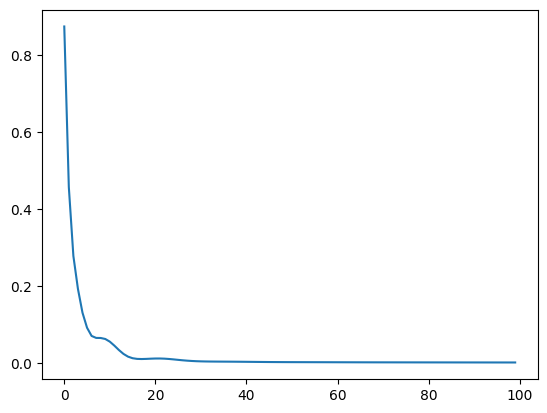

In [294]:
_ = plt.plot(lp_log["valid_loss"])

The valid dataloader isn't reproducible (for now) so I can use it to generate a new unseen set (dodgy I know... but it works).

In [295]:
lp_preds = linear_probe(torch.tensor(valid_preds).float()).detach().numpy()

In [297]:
top_k_accuracy(valid_labels, lp_preds, k=1)

1.0

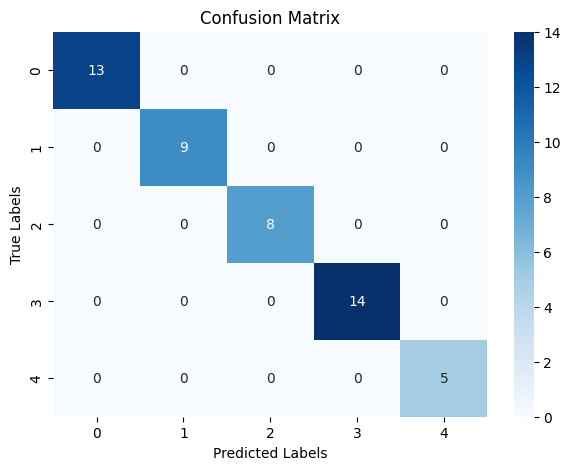

In [301]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid_labels, lp_preds.argmax(axis=1))

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()